In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import (confusion_matrix, auc, roc_curve, plot_roc_curve, 
    precision_recall_curve, plot_precision_recall_curve)

## 1. Load dataset

In [360]:
# import the titanic train data file
full = pd.read_csv('../data/train.csv', sep=',')
full.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [361]:
# create the x, y dataset
X = full.drop(['Survived'], axis=1) # drop 'Survived' as column
y = full['Survived'] # select only the 'Survived' column

In [362]:
# split the data into train and validation data
# The function train_test_split() randomly separates the data. If you want control the randomness you set the random_state to a value
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.35,random_state=42)

## 2. CHECK FOR MISSING VALUES

In [363]:
# Inspect columns genereally
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 547 to 102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  579 non-null    int64  
 1   Pclass       579 non-null    int64  
 2   Name         579 non-null    object 
 3   Sex          579 non-null    object 
 4   Age          463 non-null    float64
 5   SibSp        579 non-null    int64  
 6   Parch        579 non-null    int64  
 7   Ticket       579 non-null    object 
 8   Fare         579 non-null    float64
 9   Cabin        130 non-null    object 
 10  Embarked     578 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 54.3+ KB


In [364]:
# check columns for missing values
Xtrain.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            116
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          449
Embarked         1
dtype: int64

## 3. FEATURE ENGINEERING

In [365]:
# check balance of target data
np.sum(ytrain == 1) / len(ytrain)

0.3765112262521589

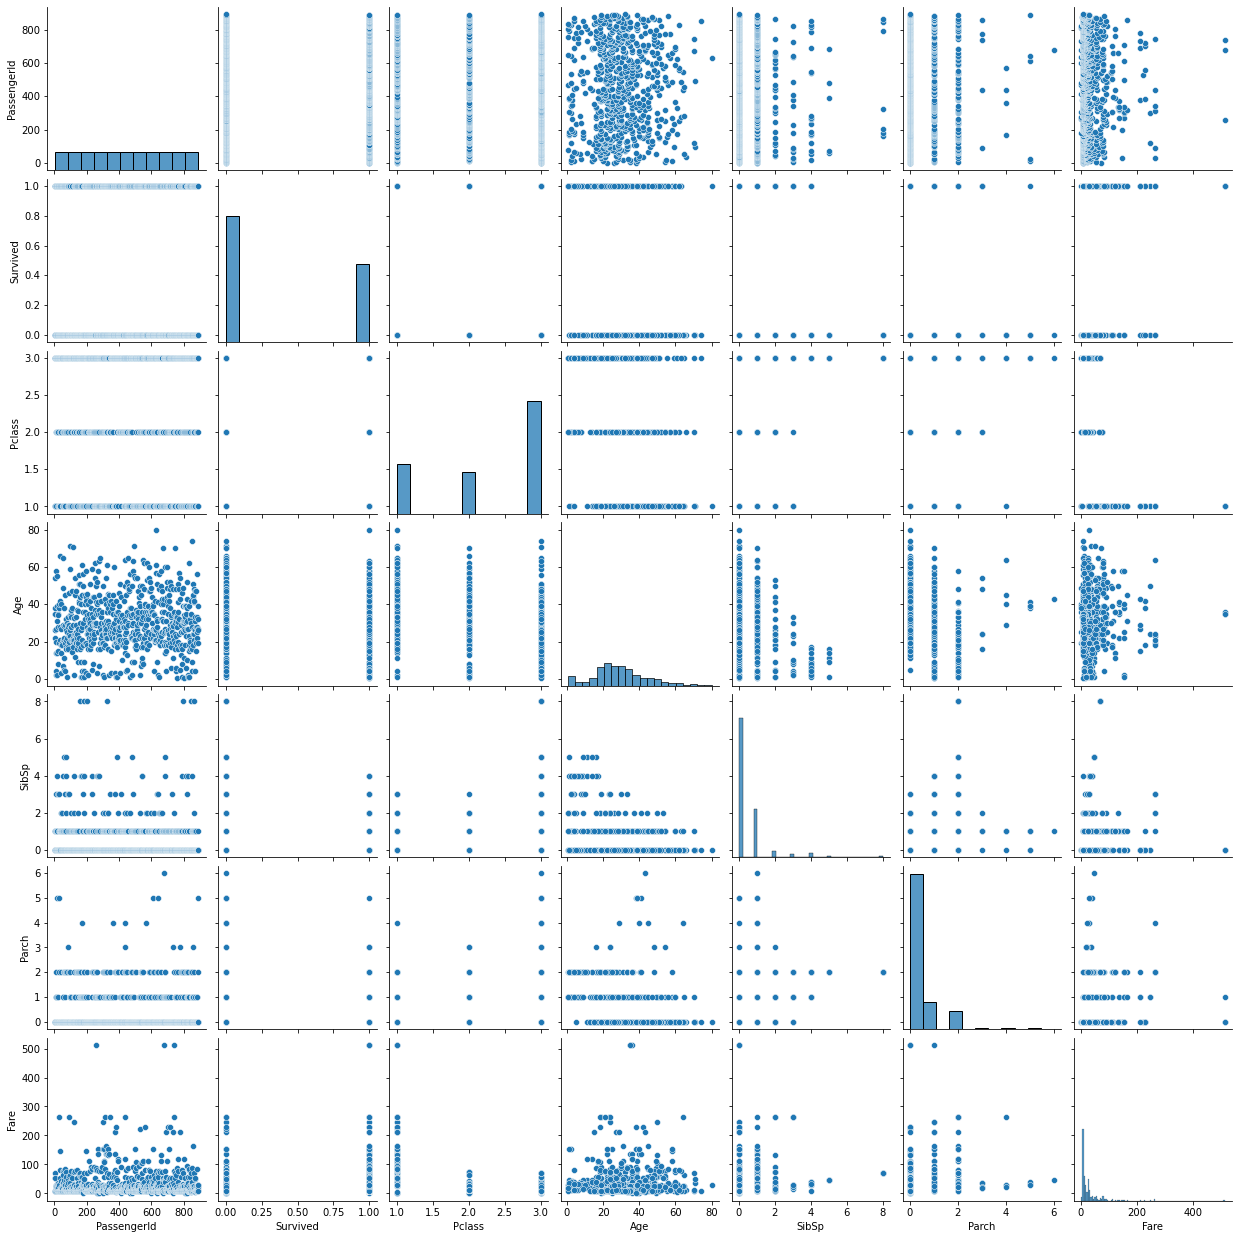

In [366]:
# create a pairplot of all features
sns.pairplot(data=full)

### 3.1 EMBARQUATION

#### 3.1.1 fill NaN with simple imputer

In [367]:
# inspect passenger embarking by class
Xtrain.groupby(by='Pclass')['Embarked'].value_counts()

Pclass  Embarked
1       S            81
        C            47
        Q             1
2       S           106
        C            12
        Q             2
3       S           238
        Q            49
        C            42
Name: Embarked, dtype: int64

In [368]:
# Fillna applying (univariate) simple inputer with most frequent strategy
inputer = SimpleImputer(strategy='most_frequent')
fill_embarqued_train = inputer.fit_transform(Xtrain[['Embarked']])
fill_embarqued_val = inputer.transform(Xval[['Embarked']])

In [369]:
# create Dataframes out of it:
df_fill_embarqued_train = pd.DataFrame(data=fill_embarqued_train, columns=['Embarqued'])
df_fill_embarqued_val = pd.DataFrame(data=fill_embarqued_val, columns=['Embarqued'])
print(f"NaN: {df_fill_embarqued_train.isna().sum()}")
df_fill_embarqued_train.head(5)

NaN: Embarqued    0
dtype: int64


,Embarqued
0,C
1,S
2,S
3,S
4,S


#### 3.1.2 change embarquation to binary variables with one hot encoder

In [370]:
# apply one hot encoding to filled embarquation data.
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
ohe_emb_train = ohe.fit_transform(df_fill_embarqued_train)
ohe_emb_val = ohe.transform(df_fill_embarqued_val)
ohe_emb_train

array([[0., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [371]:
# create Dataframes and change datatype to int
df_ohe_emb_train = pd.DataFrame(data=ohe_emb_train, columns=ohe.get_feature_names_out())
df_ohe_emb_val = pd.DataFrame(data=ohe_emb_val, columns=ohe.get_feature_names_out())
df_ohe_emb_train = df_ohe_emb_train[['Embarqued_Q', 'Embarqued_S']].astype(int)
df_ohe_emb_val = df_ohe_emb_val[['Embarqued_Q', 'Embarqued_S']].astype(int)
df_ohe_emb_train.head(5)

,Embarqued_Q,Embarqued_S
0,0,0
1,0,1
2,0,1
3,0,1
4,0,1


### 3.2. AGE 

#### 3.2.1 fill the missing NaN with the k nearest neighbor

In [372]:
# apply KNNInputer on feature Age and create a DataFrame out of the filled feature
inputer = KNNImputer()
inp_age_train = inputer.fit_transform(Xtrain[['Age']])
inp_age_val = inputer.transform(Xval[['Age']])
df_inp_age_train = pd.DataFrame(data=inp_age_train, columns=['Age'])
df_inp_age_val = pd.DataFrame(data=inp_age_val, columns=['Age'])
print(f"NaN: {df_inp_age_train.isna().sum()}")

NaN: Age    0
dtype: int64


#### 3.2.2 group the age into bins

In [373]:
# group the age into 15 equally filled bins and onehotencode the data
kbins = KBinsDiscretizer(n_bins=15, strategy='quantile', encode='onehot')
kbins_age_train = kbins.fit_transform(df_inp_age_train)
kbins_age_val = kbins.transform(df_inp_age_val)

/home/thorsten/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [374]:
# create dataframes from the binned ohe data. As the result was a sparse matrix, use .todense() to create a dense matrix
df_kbins_age_train = pd.DataFrame(data=kbins_age_train.todense(), columns=kbins.get_feature_names_out(), dtype='int')
df_kbins_age_val = pd.DataFrame(data=kbins_age_val.todense(), columns=kbins.get_feature_names_out(), dtype='int')
df_kbins_age_train.head(5)

,Age_0.0,Age_1.0,Age_2.0,Age_3.0,Age_4.0,Age_5.0,Age_6.0,Age_7.0,Age_8.0,Age_9.0,Age_10.0,Age_11.0,Age_12.0
0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0


### 3.3. SEX

#### 3.3.1 change it to numeric binary variables with one hot encoder

In [375]:
# use one hot encoding on Sex and convert the datatype to integer
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
ohe_sex_train = ohe.fit_transform(Xtrain[['Sex']])
ohe_sex_val = ohe.transform(Xval[['Sex']])
df_ohe_sex_train = pd.DataFrame(data=ohe_sex_train, columns=ohe.get_feature_names_out(), dtype='int')
df_ohe_sex_val = pd.DataFrame(data=ohe_sex_val, columns=ohe.get_feature_names_out(), dtype='int')
df_ohe_sex_train.head(5)

,Sex_male
0,1
1,1
2,1
3,0
4,0


### 3.4. Pclass 

#### 3.4.1 change passenger class to numeric binary variables with one hot encoder

In [376]:
# one hot encode passenger class (here a dense matrix (np.ndarray) will be created directly)
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
ohe_pclass_train = ohe.fit_transform(Xtrain[['Pclass']])
ohe_pclass_val = ohe.transform(Xval[['Pclass']])
df_ohe_pclass_train = pd.DataFrame(data=ohe_pclass_train, columns=ohe.get_feature_names_out(), dtype='int')
df_ohe_pclass_val = pd.DataFrame(data=ohe_pclass_val, columns=ohe.get_feature_names_out(), dtype='int')
df_ohe_pclass_train.head(5)

,Pclass_2,Pclass_3
0,1,0
1,0,1
2,0,1
3,1,0
4,0,1


### 3.5 Parch and SibSp

#### 3.5.1 create new DF with new feature "relatives" (= sibling + parents/child)

In [377]:
# create the relatives feature in new DataFrames
df_rela_train = pd.DataFrame(data=Xtrain['SibSp'] + Xtrain['Parch'], columns=['relatives'])
df_rela_val = pd.DataFrame(data=Xval['SibSp'] + Xval['Parch'], columns=['relatives'])

#### 3.5.2 group relatives into bins

In [378]:
# use KBinsDiscretizer with 5 bins using kmeans and one hot encoding
kbin = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans')
kbin_rela_train = kbin.fit_transform(df_rela_train)
kbin_rela_val = kbin.transform(df_rela_val)
print(type(kbin_rela_train))
# as sparse csr matrix was generated, use .todense()
df_kbin_rela_train = pd.DataFrame(data=kbin_rela_train.todense(), columns=kbin.get_feature_names_out())
df_kbin_rela_val = pd.DataFrame(data=kbin_rela_val.todense(), columns=kbin.get_feature_names_out())
df_kbin_rela_train.head(5)

<class 'scipy.sparse.csr.csr_matrix'>


,relatives_0.0,relatives_1.0,relatives_2.0,relatives_3.0,relatives_4.0
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


### 3.6 Fare

#### 3.6.1 Alternative 1: use MaxMinScaler on fare

In [379]:
# Scale the fare form 0 - 1 and create DataFrames
scaler = MinMaxScaler()
scal_fare_train = scaler.fit_transform(Xtrain[['Fare']])
scal_fare_val = scaler.transform(Xval[['Fare']])
df_scale_fare_train = pd.DataFrame(data=scal_fare_train, columns=scaler.get_feature_names_out())
df_scale_fare_val = pd.DataFrame(data=scal_fare_val, columns=scaler.get_feature_names_out())
df_scale_fare_train.describe()

,Fare
count,579.000000
mean,0.062421
std,0.101701
min,0.000000
25%,0.015412
50%,0.028107
75%,0.060020
max,1.000000


#### 3.6.2 Alternative 2: group fare into bins

In [380]:
# use KBinsDiscretizer with 5 equally filled bins and one hot encoding
kbin = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='quantile')
kbin_fare_train = kbin.fit_transform(Xtrain[['Fare']])
kbin_fare_val = kbin.transform(Xval[['Fare']])
# as sparse csr matrix was generated, use .todense()
df_kbin_fare_train =  pd.DataFrame(data=kbin_fare_train.todense(), columns=kbin.get_feature_names_out())
df_kbin_fare_val =  pd.DataFrame(data=kbin_fare_val.todense(), columns=kbin.get_feature_names_out())
df_kbin_fare_train.head(5)

,Fare_0.0,Fare_1.0,Fare_2.0,Fare_3.0,Fare_4.0
0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0


### 3.7 Parch

#### 3.7.1 scale Parch from 0 to 1

In [381]:
# use MinMaxScaler on Parch
scaler = MinMaxScaler()
scal_parch_train = scaler.fit_transform(Xtrain[['Parch']])
scal_parch_val = scaler.transform(Xval[['Parch']])
df_scale_parch_train = pd.DataFrame(data=scal_parch_train, columns=scaler.get_feature_names_out())
df_scale_parch_val = pd.DataFrame(data=scal_parch_val, columns=scaler.get_feature_names_out())

### 3.8 SibSp

#### 3.8.1 scale SibSp from 0 to 1

In [382]:
# use MinMaxScaler on sibsp
scal_sibsp_train = scaler.fit_transform(Xtrain[['SibSp']])
scal_sibsp_val = scaler.transform(Xval[['SibSp']])
df_scale_sibsp_train = pd.DataFrame(data=scal_sibsp_train, columns=scaler.get_feature_names_out())
df_scale_sibsp_val = pd.DataFrame(data=scal_sibsp_val, columns=scaler.get_feature_names_out())

### 3.9 Title

In [383]:
# some names have a title (mainly Mrs, Ms, Mr. but also Colonel, Referend etc.)
Xval[['Name']][-5:]

,Name
132,"Robins, Mrs. Alexander A (Grace Charity Laury)"
694,"Weir, Col. John"
864,"Gill, Mr. John William"
185,"Rood, Mr. Hugh Roscoe"
41,"Turpin, Mrs. William John Robert (Dorothy Ann ..."


#### 3.9.1 extract the title from the name of the passenger

In [384]:
# extract info from name
def title_extraction(df):
    '''extracts the title from the name feature,
        clusters it into 4 categories: 0: special title (e.g. Colonel, Baron), 1: Mr, 2: Mrs, 3: Miss
        and returns a dataframe with the title class'''
    # extract the 1. part of the 1st name 
    title = df['Name'].str.split(',', expand = True)
    title = title[title.columns[1]].str.split('.', expand = True)
    title = title[title.columns[0]]
    title = title.str.strip()
    # transform series to dataframe and add column-title
    df_title = pd.DataFrame(data=title)
    df_title.columns=['Title']
    # group the extracted titles
    df_title['Title_no'] = 0
    df_title.loc[df_title['Title'] == 'Mr', 'Title_no'] = 1
    df_title.loc[df_title['Title'] == 'Mrs', 'Title_no'] = 2
    df_title.loc[df_title['Title'] == 'Miss', 'Title_no'] = 3
    df_title.drop(['Title'], axis= 1, inplace=True)
    return df_title

df_title_train = title_extraction(Xtrain)
df_title_val = title_extraction(Xval)
df_title_train.value_counts()


Title_no
1           340
3           121
2            75
0            43
dtype: int64

#### 3.9.2 change title to numeric binary variables with one hot encoder

In [385]:
# use one hot encode on title
ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore',)
ohe_train = ohe.fit_transform(df_title_train[['Title_no']])    
df_ohe_title_train = pd.DataFrame(data=ohe_train, columns=ohe.get_feature_names_out(), dtype='int')
ohe_val = ohe.transform(df_title_val[['Title_no']])
df_ohe_title_val = pd.DataFrame(data=ohe_val, columns=ohe.get_feature_names_out(), dtype='int')

## 4. Concatenate all feature DataFrames

In [386]:
Xtrain_fe = pd.concat([df_kbins_age_train, df_ohe_sex_train, df_ohe_pclass_train, df_scale_sibsp_train, 
    df_scale_parch_train, df_ohe_title_train], axis=1)
Xval_fe = pd.concat([df_kbins_age_val, df_ohe_sex_val, df_ohe_pclass_val, df_scale_sibsp_val, 
    df_scale_parch_val, df_ohe_title_val], axis=1)
Xtrain_fe.head(5)

,Age_0.0,Age_1.0,Age_2.0,Age_3.0,Age_4.0,Age_5.0,Age_6.0,Age_7.0,Age_8.0,Age_9.0,...,Age_11.0,Age_12.0,Sex_male,Pclass_2,Pclass_3,SibSp,Parch,Title_no_1,Title_no_2,Title_no_3
0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0.0,0.000000,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0.0,0.000000,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0.0,0.000000,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0.0,0.000000,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0.0,0.333333,0,1,0


In [387]:
# check shape of concatenated DataFrames
Xtrain_fe.shape, Xval_fe.shape

((579, 21), (312, 21))

## 5. Predict survivors

### 5.1 use LOGISTIC REGRESSION MODEL

In [388]:
# instatiate and train the model
# class_weight balanced penalizes class 0 relatively to class 1 in loss function
model_log = LogisticRegression(class_weight='balanced')
model_log.fit(Xtrain_fe, ytrain)

LogisticRegression(class_weight='balanced')

In [389]:
# calculate precision for train and validation data
model_log.score(Xtrain_fe, ytrain), model_log.score(Xval_fe, yval),

(0.8151986183074266, 0.8141025641025641)

### 5.2 use a DECISION TREE MODEL

In [390]:
# Define and train the model
model_tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=10, criterion='gini')
model_tree.fit(Xtrain_fe, ytrain)

DecisionTreeClassifier(max_depth=10)

In [391]:
# calculate the accurancy of the decision tree
model_tree.score(Xtrain_fe, ytrain), model_tree.score(Xval_fe, yval),

(0.8877374784110535, 0.8333333333333334)

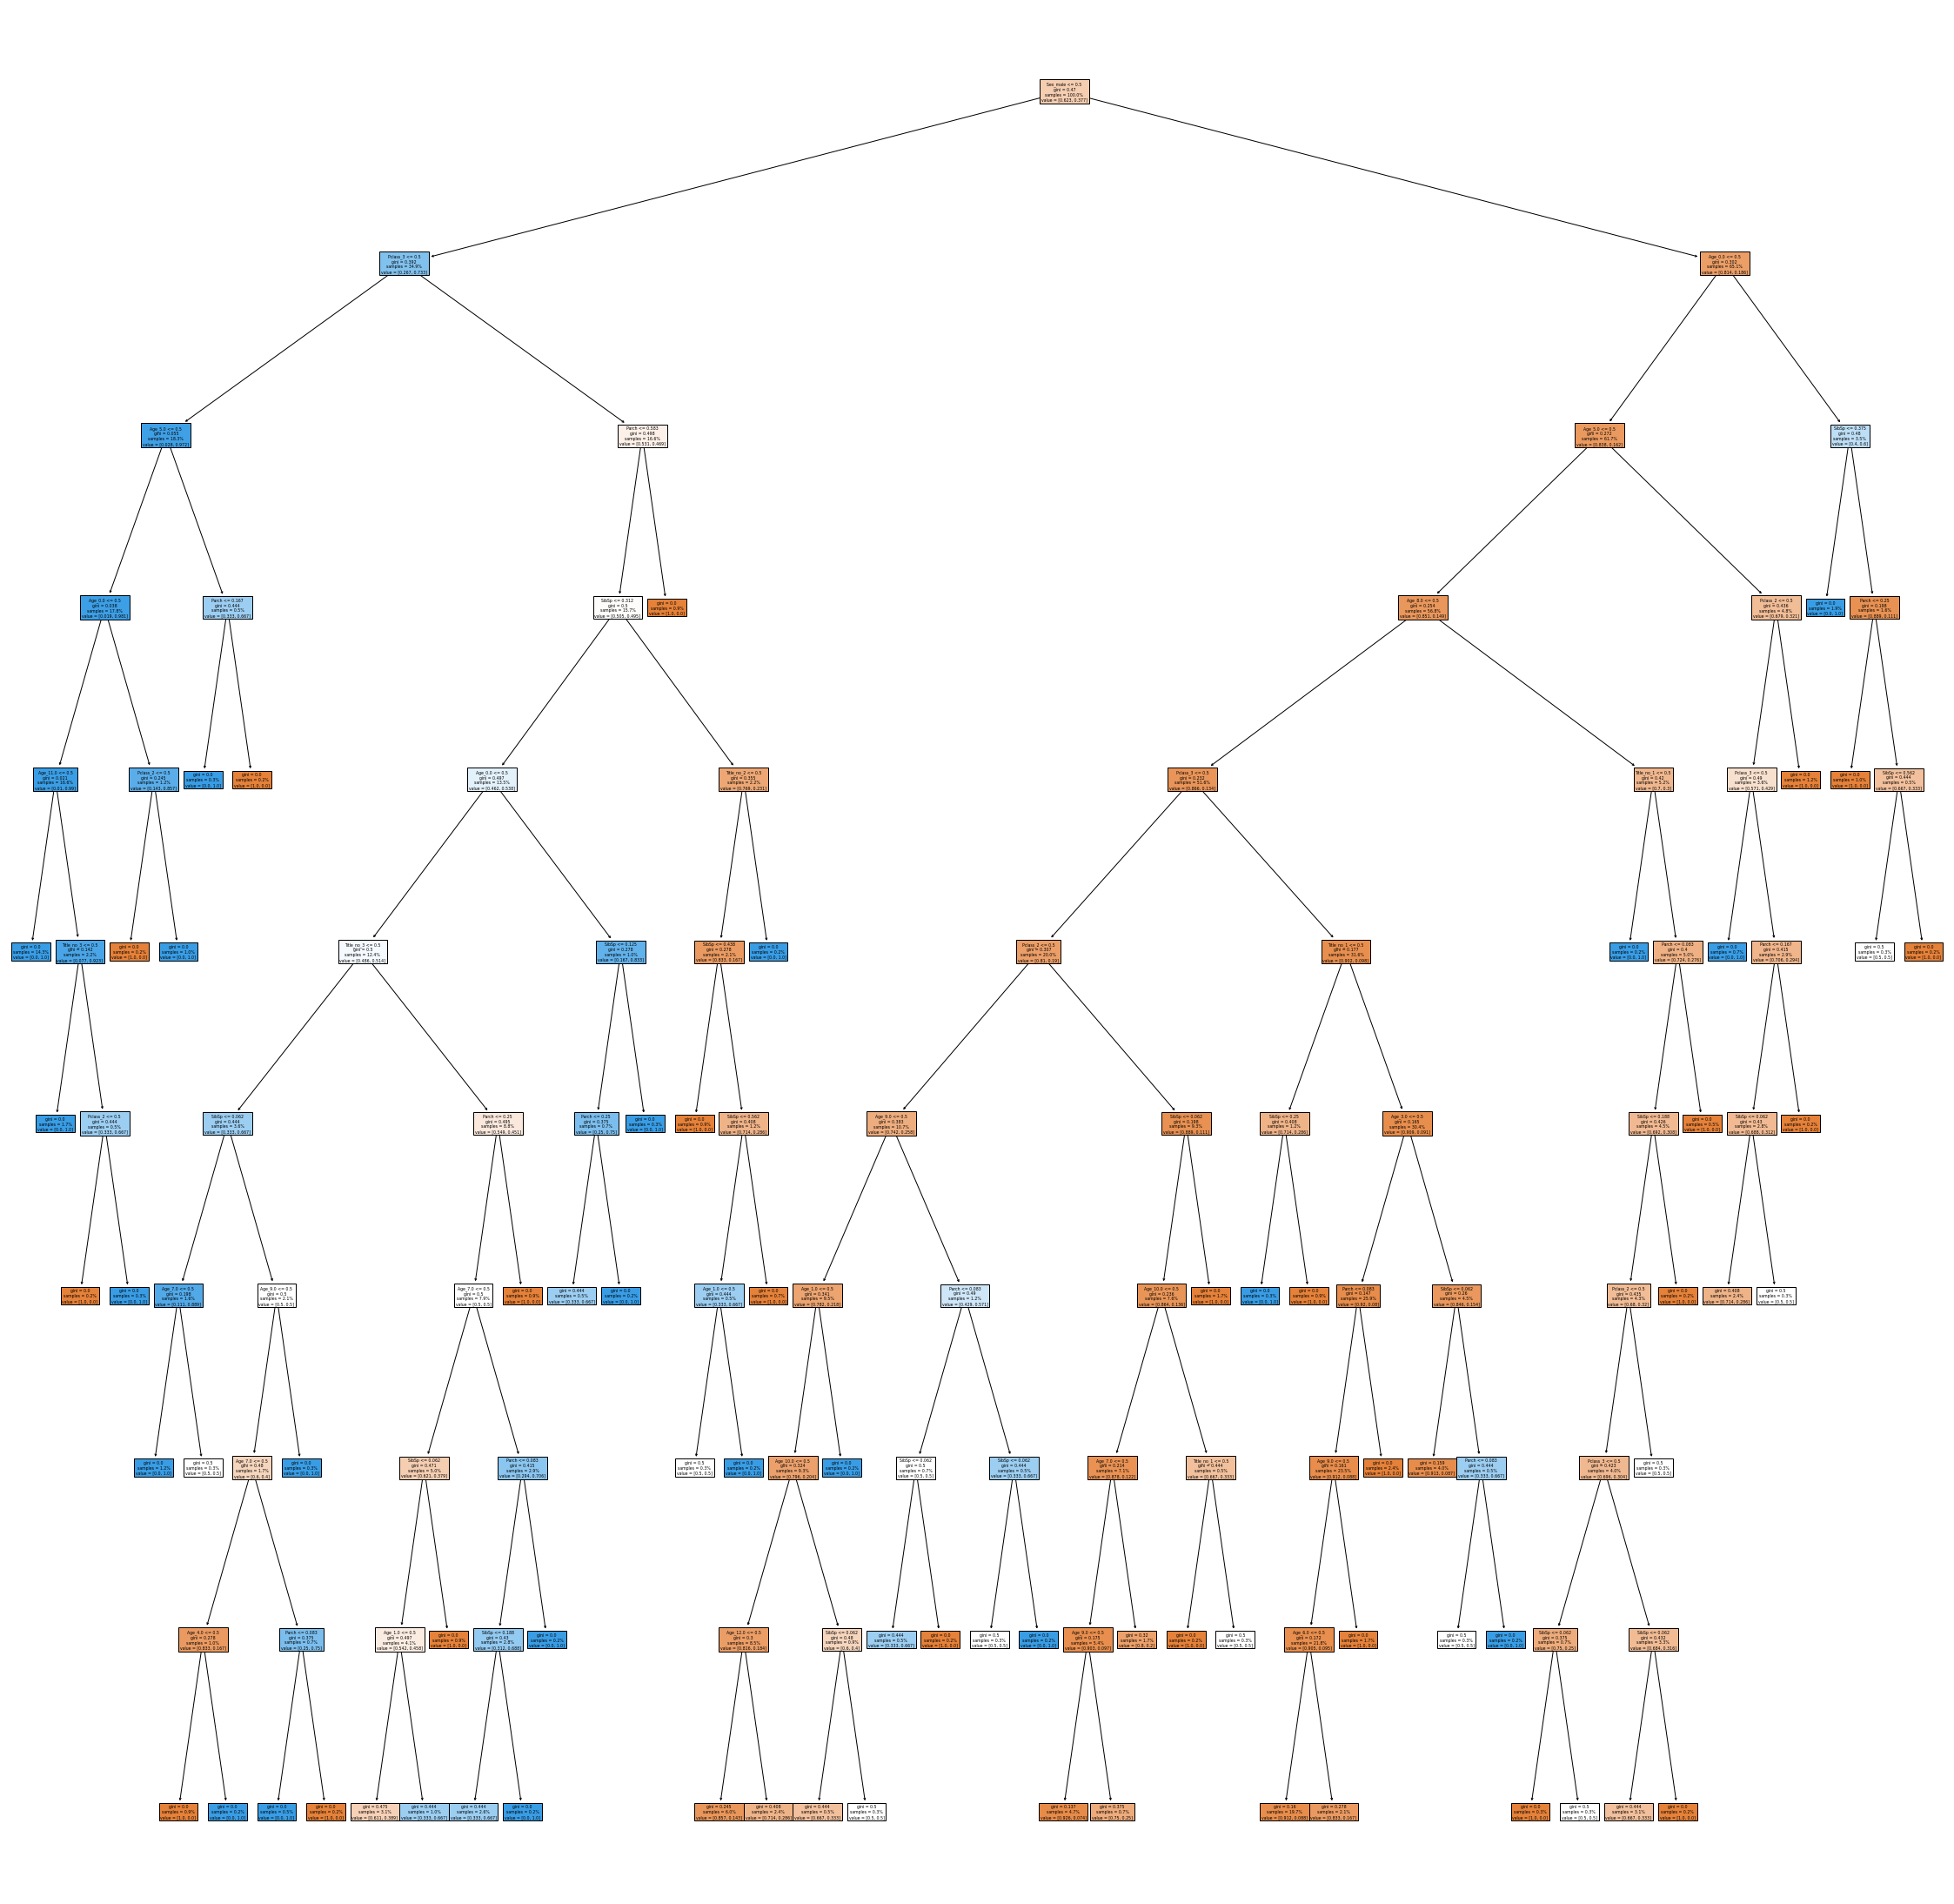

In [392]:
# plot the decision tree
plt.figure(figsize=(40, 40))
t = plot_tree(model_tree, feature_names=Xtrain_fe.columns, filled=True, proportion=True)

### 5.3 use RANDOM FOREST MODEL

In [393]:
# instantiate and train the RFC 
model_rf = RandomForestClassifier(n_estimators=130, criterion="gini", max_depth=15)
model_rf.fit(Xtrain_fe, ytrain)


RandomForestClassifier(max_depth=15, n_estimators=130)

In [394]:
# calculate the accurancy of the RFC
model_rf.score(Xtrain_fe, ytrain), model_rf.score(Xval_fe, yval)

(0.8929188255613126, 0.8365384615384616)

### 5.4 use SUPPORT VECTOR MACHINE MODEL

#### 5.4.1 use linear SVC

In [395]:
# instantiate and train the linear SVC
model_svm_linear_svc = svm.LinearSVC(C=1.0)
model_svm_linear_svc.fit(Xtrain_fe, ytrain)

LinearSVC()

In [396]:
# calculate the accurancy of the linear SVC
model_svm_linear_svc.score(Xtrain_fe, ytrain), model_svm_linear_svc.score(Xval_fe, yval)

(0.8255613126079447, 0.8108974358974359)

#### 5.4.2 use SVC

In [397]:
# instantiate and train the SVC
model_svm_svc = svm.SVC(kernel='rbf', C=1.0)
model_svm_svc.fit(Xtrain_fe, ytrain)

SVC()

In [398]:
# calculate the accurancy of the SVC
model_svm_svc.score(Xtrain_fe, ytrain), model_svm_svc.score(Xval_fe, yval)

(0.8341968911917098, 0.7948717948717948)

## 6. COMPARE THE MODELS

### 6.1 Accuracy

In [399]:
# create a list with all models and their names
models_list = [('logistic regression', model_log), ('decision tree', model_tree), 
    ('random forest', model_rf), ('SVM SVC', model_svm_svc)]
# print the trainings and validation accuracy for each model
for name, model in models_list:
    print(f"{name}: train: {np.round(model.score(Xtrain_fe, ytrain), 3)} val: {np.round(model.score(Xval_fe, yval), 3)}")

logistic regression: train: 0.815 val: 0.814
decision tree: train: 0.888 val: 0.833
random forest: train: 0.893 val: 0.837
SVM SVC: train: 0.834 val: 0.795


In [400]:
# print the feature importance of the random forest classifier
model_rf.feature_importances_

array([0.02685952, 0.01186196, 0.01091895, 0.01077699, 0.0111415 ,
       0.02714741, 0.01484994, 0.02197306, 0.01561125, 0.01500904,
       0.01435319, 0.01375349, 0.01053917, 0.1591957 , 0.05015939,
       0.11407099, 0.11870829, 0.07411468, 0.1633646 , 0.05997393,
       0.05561693])

### 6.2 Confusion matrix

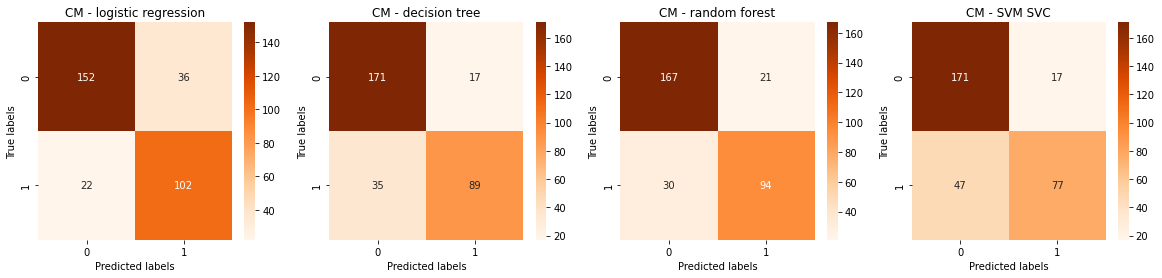

In [401]:
# plot the confusion matrices of all models with validation data
fig, axs = plt.subplots(figsize=(20, 4), nrows=1, ncols=4)
for i, (name, model) in enumerate(models_list):
    conf_log = confusion_matrix(yval, model.predict(Xval_fe))
    sns.heatmap(conf_log, annot=True, ax = axs[i], fmt='g', cmap = 'Oranges')
    axs[i].set_xlabel('Predicted labels')
    axs[i].set_ylabel('True labels')
    axs[i].set_title('CM - ' + name)

### 6.3 ROC Curves

/home/thorsten/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/thorsten/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/thorsten/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is depre

AUC logistic regression = 0.8674
AUC decision tree = 0.8514
AUC random forest = 0.865


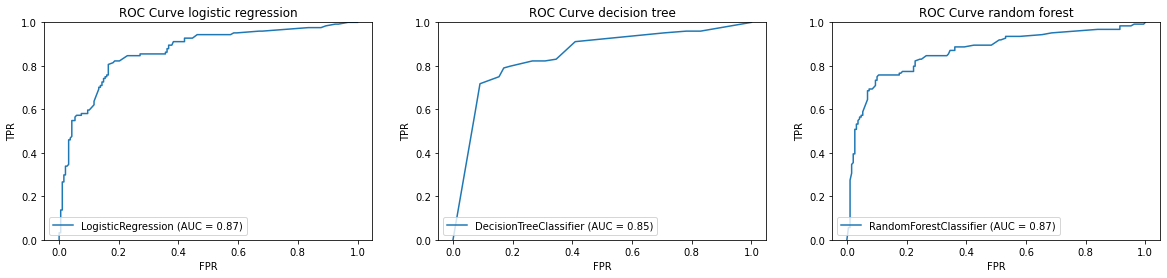

In [402]:
# plot the ROC curve of all models (except SVM model) with validation data
fig, axs = plt.subplots(figsize=(20, 4), nrows=1, ncols=3)
for i, (name, model) in enumerate(models_list[:-1]):
    probs = model.predict_proba(Xval_fe)
    fpr, tpr, threshold = roc_curve(yval, probs[:, 1]) 
    auc_model = np.round(auc(fpr, tpr), 4) # parameters: false positive rate, true positive rate
    plot_roc_curve(model, Xval_fe, yval, ax=axs[i]);  
    axs[i].set_title("ROC Curve " + name)
    axs[i].set_ylabel("TPR")
    axs[i].set_xlabel("FPR")
    axs[i].legend(loc="lower left")
    axs[i].set_ylim([0,1.00])
    print(f"AUC {name} = {auc_model}") 

### 6.4 Precision Recall Curve


AUC logistic regression= 0.8152180521539789
AUC decision tree= 0.824686851986089
AUC random forest= 0.8234238194851522


/home/thorsten/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/tmp/ipykernel_9391/3083669580.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axs[i, 1].grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)
/home/thorsten/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.fr

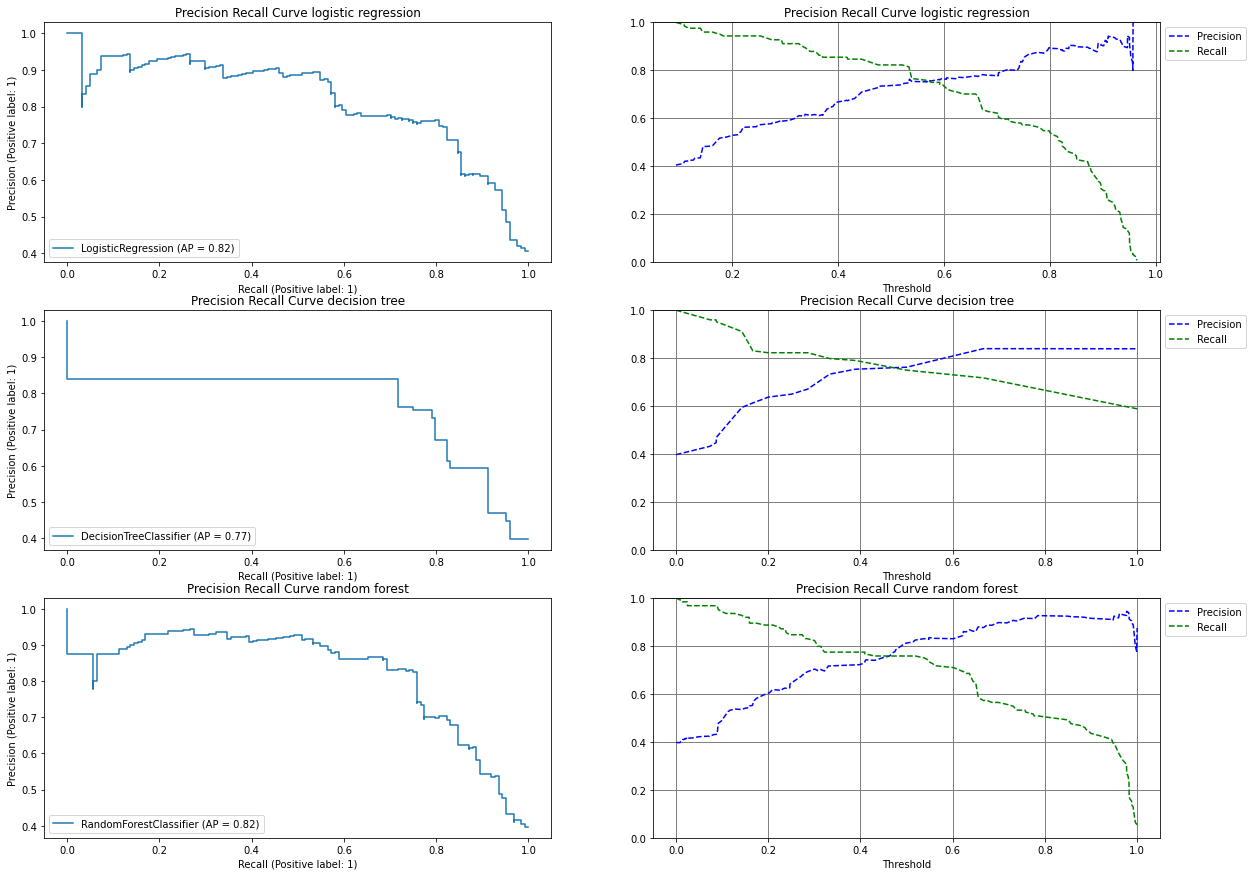

In [403]:

# plot the curces for the logistic regression, decision tree and random forest models with validation data
fig, axs = plt.subplots(figsize=(20, 15), nrows=3, ncols=2)
for i, (name, model) in enumerate(models_list[:3]):
    # plot precision and recall curve 
    probs = model.predict_proba(Xval_fe)
    precisions, recalls, thresholds = precision_recall_curve(yval, probs[:, 1])
    pr_auc = auc(recalls, precisions)
    print(f"AUC {name}= {pr_auc}")
    plot_precision_recall_curve(model, Xval_fe, yval, ax=axs[i, 0])
    axs[i, 0].set_title(f"Precision Recall Curve {name}")
    # plot precision recall depending on threshold
    axs[i, 1].plot(thresholds, precisions[:-1], "b--", label="Precision")
    axs[i, 1].plot(thresholds, recalls[:-1], "g--", label="Recall")
    axs[i, 1].set_xlabel("Threshold")
    axs[i, 1].legend(bbox_to_anchor=(1, 1), loc='upper left')
    axs[i, 1].grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)
    axs[i, 1].set_title(f"Precision Recall Curve {name}")
    axs[i, 1].set_ylim(0,1)